# Imports

In [2]:
import faiss
import numpy as np

from collections import defaultdict

import pandas as pd

from src.helper import create_embeddings, create_index, semantic_similarity, call_llm

# Load the dataset

In [3]:
df =  pd.read_csv('Customer_Support_Training_Dataset/Customer_Support_Training_Dataset.csv')
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


<AxesSubplot: xlabel='category'>

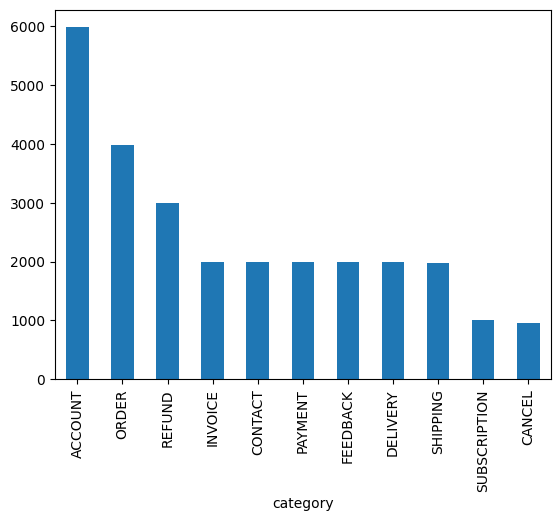

In [4]:
# look at the categories present in the dataset and their counts (Distribution)
# dataset is not uniformly distributed
df['category'].value_counts().plot(kind='bar')

In [5]:
# Create a dictionary where the key is 'category' column and the value is a list of unique 'intent' column values
category_intent_dict = defaultdict(set)
for category, intent in zip(df['category'], df['intent']):
    category_intent_dict[category].add(intent)

# Convert defaultdict to regular dict and sets to lists for display
category_intent_dict = {k: list(v) for k, v in category_intent_dict.items()}

category_intent_dict

{'ORDER': ['track_order', 'place_order', 'change_order', 'cancel_order'],
 'SHIPPING': ['change_shipping_address', 'set_up_shipping_address'],
 'CANCEL': ['check_cancellation_fee'],
 'INVOICE': ['get_invoice', 'check_invoice'],
 'PAYMENT': ['check_payment_methods', 'payment_issue'],
 'REFUND': ['check_refund_policy', 'track_refund', 'get_refund'],
 'FEEDBACK': ['complaint', 'review'],
 'CONTACT': ['contact_customer_service', 'contact_human_agent'],
 'ACCOUNT': ['recover_password',
  'edit_account',
  'registration_problems',
  'delete_account',
  'switch_account',
  'create_account'],
 'DELIVERY': ['delivery_period', 'delivery_options'],
 'SUBSCRIPTION': ['newsletter_subscription']}

In [6]:
# Calculate the avg. token count for instructions and responses using the split method
avg_instruction_token_count = df['instruction'].apply(lambda x: len(x.split())).mean()
avg_response_token_count = df['response'].apply(lambda x: len(x.split())).mean()

print(f'Avg. token count for instructions: {avg_instruction_token_count}')
print(f'Avg. token count for responses: {avg_response_token_count}')

Avg. token count for instructions: 8.690979458172075
Avg. token count for responses: 104.78903691574874


# Vectorization of the dataset

In [ ]:
#enter the column to vectorize and model of openai to be used
vectors = create_embeddings(df, column_name='instruction', model='text-embedding-3-small') 

In [ ]:
#check the shape of the vectors
vectors.shape

In [ ]:
#save the embeddings to a vector DB
index = create_index(vectors, index_file_path='vector_store/faiss_index.index')

# Load the vector DB

In [ ]:
index = faiss.read_index('vector_store/faiss_index.index')

## User query

In [ ]:
#Enter the inbound query and execute bottom cells to get the response
query = "change my address"

In [ ]:
distances, indices = semantic_similarity(query, index, model='text-embedding-3-small')

#search the original dataframe for the similar instructions and pass it to a new dataframe 
top_similar_instructions = df.iloc[indices[0]].reset_index(drop=True)
top_similar_instructions['distance'] = distances[0]

In [ ]:
responses = top_similar_instructions['response'].to_list()
print('---#################----')
print("Responses from the dataset:\n", top_similar_instructions[['instruction', 'intent', 'response']].to_markdown(index=False))
print('---#################----')
print("Response from LLM:\n", call_llm(query, responses))